# Mice sleep
This jupiter notebook should show the implementation described in the project report. 


## Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import helpers
import features
import plots

## Data import
We add directly the artifical features `time`, `day`and `hours` to our dataset. This represents better the fact, that the measurments have been taken each 4 seconds over a timespan of 4 days.

In [14]:
data_folder = 'data/'
file = '10101.csv'

df = features.load_features(data_folder + file)

# adding time features

df = features.add_times(df)

def to_hours(tick):
    return tick / 900.0

df['hours'] = df.index.map(to_hours)

## Data exploration


### Size of single mouse data set
Each 4 seconds over 4 days a datapoint is taken.

In [15]:
df.shape[0]

86400

### Given features
Where the `rawState` column can have a values `['n', 'r', 'w', 1, 2, 3, 5, 6]` and the `state` column can have the state `['n', 'r', 'w']`

In [16]:
df.head()

,rawState,state,EEGv,EMGv,temp,time,day,hours
0,w,w,3.342858e-09,1.083345e-09,0.0,0,0,0.000000
1,w,w,3.131613e-09,5.783424e-09,0.0,1,0,0.001111
2,w,w,3.202955e-09,1.809423e-09,0.0,2,0,0.002222
3,w,w,3.295155e-09,1.861343e-09,0.0,3,0,0.003333
4,w,w,3.245190e-09,1.245901e-08,0.0,4,0,0.004444


### State
The mouse is either in 'w' = awake, 'n'= rem sleep and 'n' = Not Rem Sleep phase. Listed below the time distribution of the different states in the first day. And the number of elements in each state.

state
n    33955
r     3695
w    48750
dtype: int64


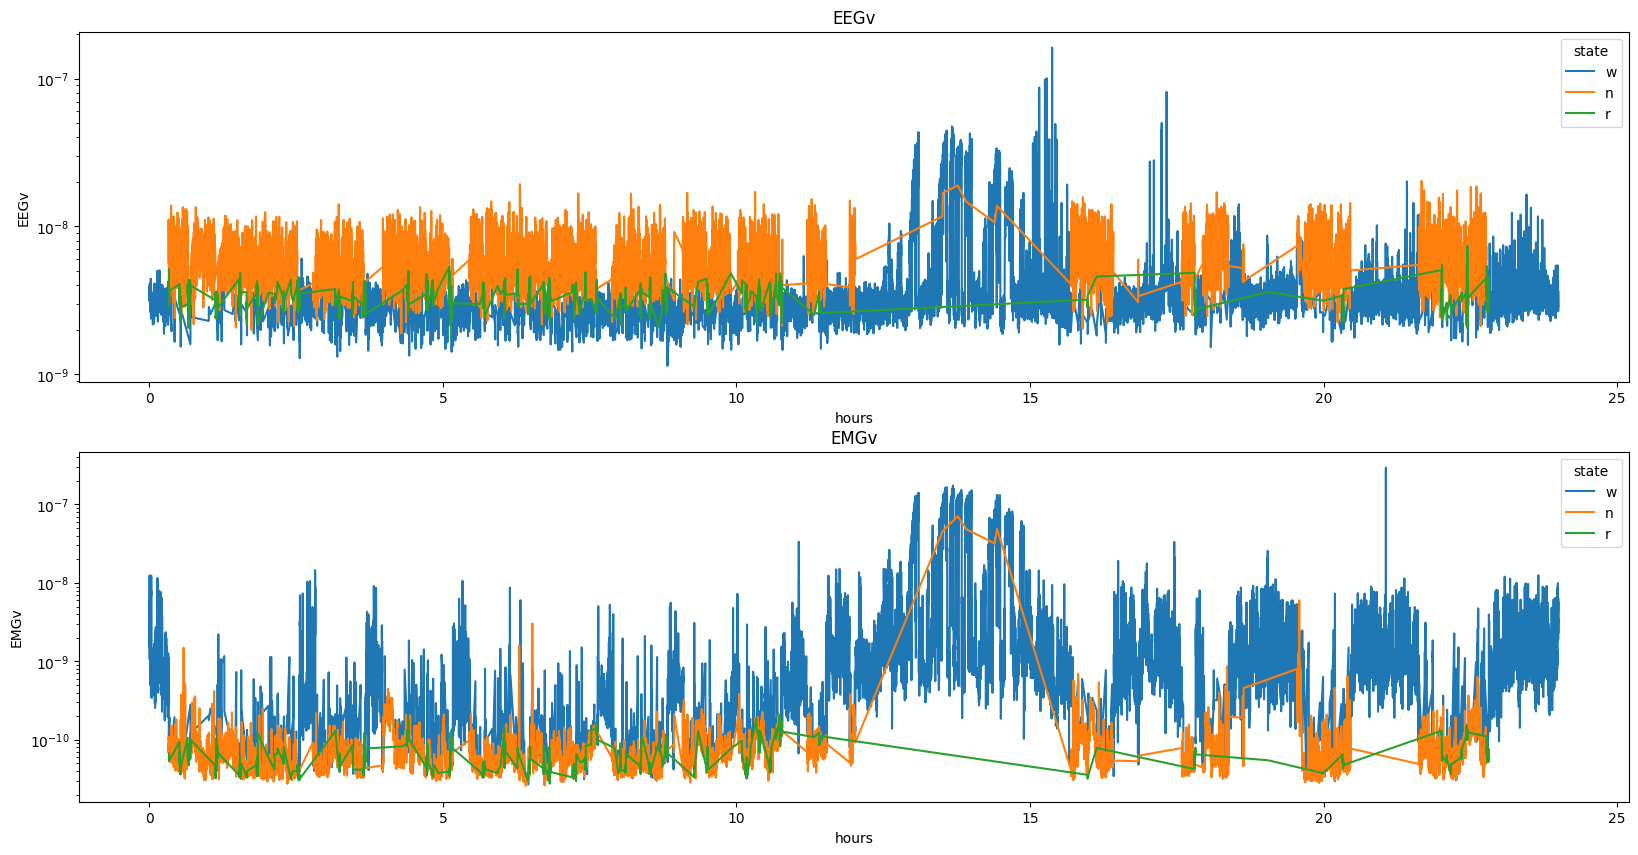

In [17]:
print(df.groupby('state').size())

plots.plot_df(data=df, day=0, log=True)


### Relation between EEGv and EMGv over all 4 days

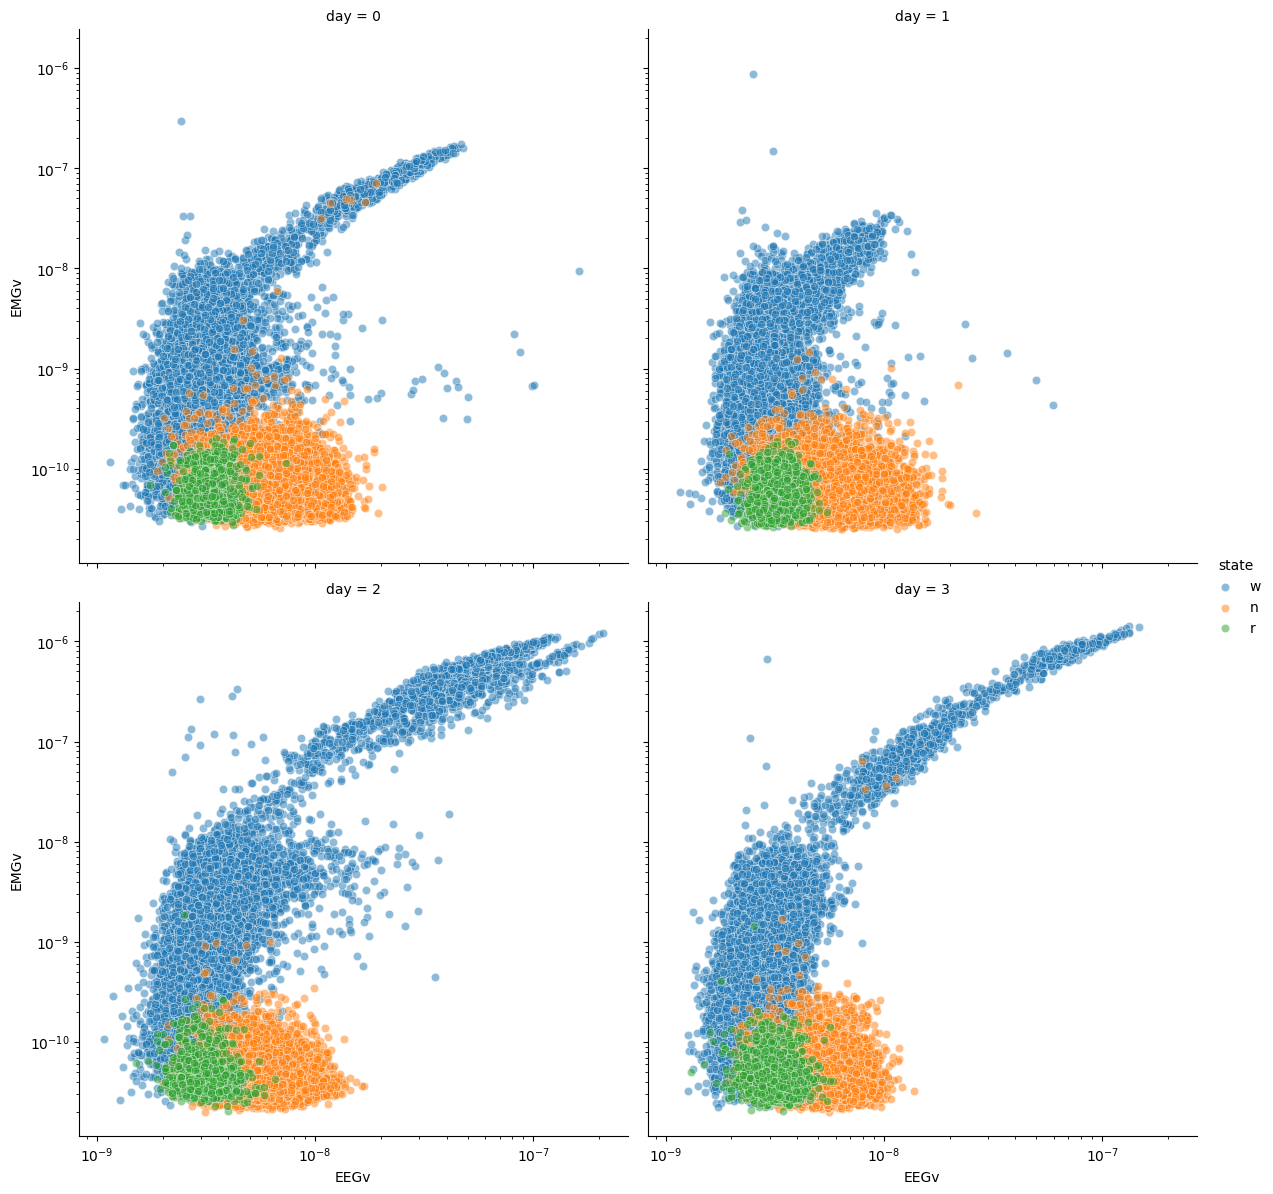

In [18]:
plots.scatter(data=df)

### EEGv and EMGv for first day

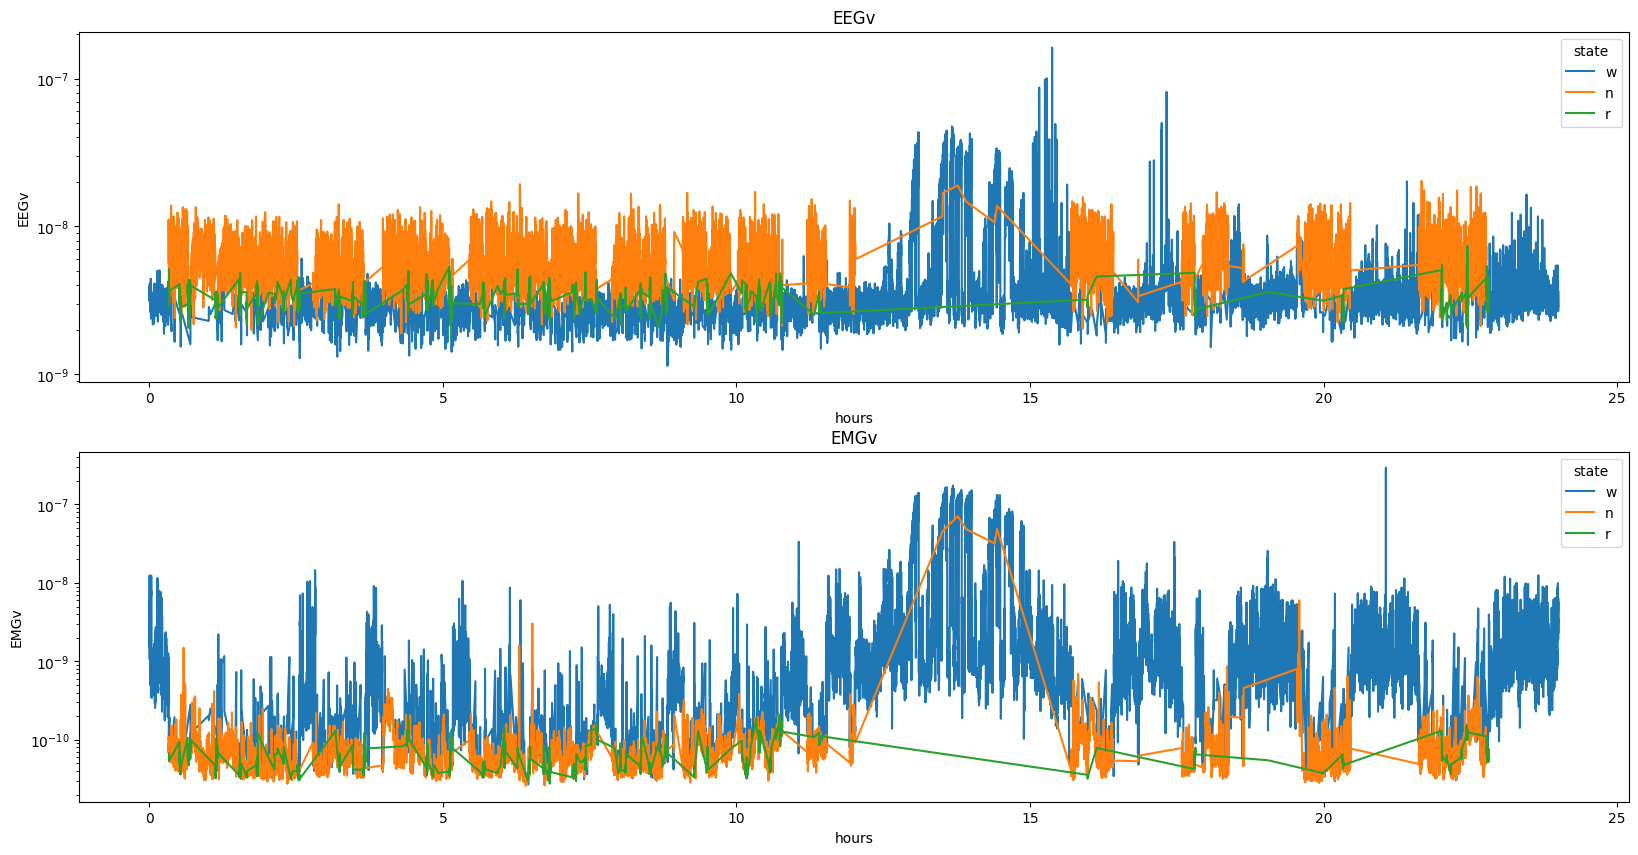

In [19]:
plots.plot_df(data=df, day=0, log=True)

## Feature engineering
TODOs:
- [ ] Rebalancing of the data set
- [ ] Computing some aggregates per individual (min, max)
- [ ] Why do we need `df.dropna()` for the rolling windows?

### Log feature, standardize, adding non-linearity and adding trigometric features

In [20]:
degree = 2
df = helpers.log_features(df, features=['EEGv', 'EMGv'])
df = helpers.standardize(df, features=['EEGv', 'EMGv'])
df = helpers.expand_features_poly(
        df, degree, features=['EEGv', 'EMGv'],
    )
df = helpers.expand_features_trigonometric(df, ['EEGv', 'EMGv'])


### Rolling window

In [21]:
window_size = 50
df = features.features_window(df, window_size=window_size, op=features.WindowOperationFlag.MEAN, features=["EEGv", "EMGv"])
df = df.dropna()

  rawState state      EEGv      EMGv  temp  time  day     hours    EEGv^2  \
0        w     w -0.426085  0.586794   0.0     0    0  0.000000  0.181548   
1        w     w -0.539291  1.366027   0.0     1    0  0.001111  0.290835   
2        w     w -0.500227  0.825436   0.0     2    0  0.002222  0.250227   
3        w     w -0.451011  0.838598   0.0     3    0  0.003333  0.203411   
4        w     w -0.477508  1.723067   0.0     4    0  0.004444  0.228014   

     EMGv^2  bias  EEGv_sin  EEGv_cos  EMGv_sin  EMGv_cos  EEGv_mean  \
0  0.344328     1 -0.413309  0.910591  0.553695  0.832720        NaN   
1  1.866031     1 -0.513528  0.858073  0.979108  0.203341        NaN   
2  0.681345     1 -0.479624  0.877474  0.734844  0.678237        NaN   
3  0.703246     1 -0.435875  0.900007  0.743706  0.668507        NaN   
4  2.968961     1 -0.459568  0.888143  0.988429 -0.151683        NaN   

   EMGv_mean  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
   rawState st

## Model fitting
We only considering for the moment the **first day**. We don't use the raw state.

In [22]:
seed = 42
days = [0]
useRaw = False
test_size = 0.2
cat_matrix = True # True for neural net, any for random forest
x_train, x_test, y_train, y_test, le = features.split_data(df, useRaw, test_size, seed, cat_matrix)


### Random forests

[[6629   67  171]
 [ 437  213  133]
 [ 391   68 9162]]
              precision    recall  f1-score   support

           n       0.89      0.97      0.93      6867
           r       0.61      0.27      0.38       783
           w       0.97      0.95      0.96      9621

    accuracy                           0.93     17271
   macro avg       0.82      0.73      0.75     17271
weighted avg       0.92      0.93      0.92     17271



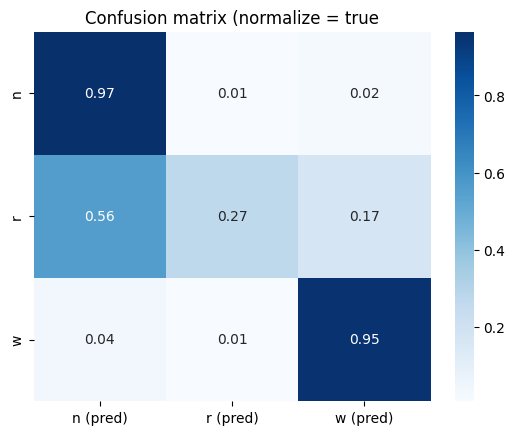

"Score": 0.9122228012274912


In [23]:
rfc = RandomForestClassifier(random_state=seed)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)

plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')
print(f'\"Score\": {rfc.score(x_test, y_test)}')